# 0. OpenCV with contrib libraries

In [3]:
!pip install opencv-contrib-python opencv-python

     |████████████████████████████████| 56.4 MB 150 kB/s eta 0:00:01    |█▎                              | 2.2 MB 1.2 MB/s eta 0:00:45     |█▍                              | 2.5 MB 4.2 MB/s eta 0:00:13     |██████████████████████▊         | 40.1 MB 3.7 MB/s eta 0:00:05
     |████████████████████████████████| 50.4 MB 151 kB/s eta 0:00:012    |██████▍                         | 10.1 MB 5.5 MB/s eta 0:00:08     |██████████████▍                 | 22.6 MB 4.3 MB/s eta 0:00:07
You should consider upgrading via the '/home/credog/anaconda3/bin/python -m pip install --upgrade pip' command.


# 1. Download data 
from [this kaggle dataset](https://www.kaggle.com/pmigdal/alien-vs-predator-images). Unpack it to some folder.

Use the following code to read the data. The data will be stored in the following arrays:
- `X_train`, `X_test` - lists of 2D `np.array`s storing grayscaled images.
- `y_train`, `y_test` - lists of text labels (`alien`, `predator`).

In [3]:
dataset_dir = "datasets/avsp/data"

import cv2
import os

def load_dataset_part(folder):
    result = []
    for i in os.listdir(folder):
        fn = os.path.join(folder, i)
        if os.path.isfile(fn):
            img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY)
            result.append(img)
    return result


def load_dataset(folder, train=True):
    part = 'train' if train else 'validation'
    aliens = load_dataset_part(os.path.join(folder, part, 'alien'))
    predators = load_dataset_part(os.path.join(folder, part, 'predator'))
    X = aliens + predators
    y = ['alien'] * len(aliens) + ['predator'] * len(predators)
    return X, y
    
X_train, y_train = load_dataset(os.path.join(dataset_dir))
X_test, y_test = load_dataset(os.path.join(dataset_dir), train=False)

print(f"Train size {len(X_train)}, Test size {len(X_test)}")

Train size 694, Test size 200


alien


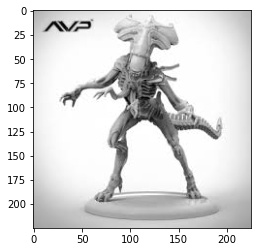

predator


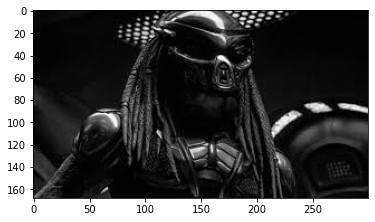

In [4]:
import matplotlib.pyplot as plt

print(y_train[13])
plt.imshow(X_train[13], cmap='gray')
plt.show()

print(y_train[-13])
plt.imshow(X_train[-13], cmap='gray')
plt.show()

# 2. Compute SIFT desciptors
Compute SIFT descriptors for every image. You can use `detectAndCompute(...)` method, please refer to documentation or, e.g. [this tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html). 

**NB Each image will produce unpredictable (different) number of SIFT vectors. Store them in matrices**

In [5]:
kp, des=sift.detectAndCompute(X_train[0],None)
des

NameError: name 'sift' is not defined

In [6]:
sift = cv2.xfeatures2d.SIFT_create()
X_train_sift = []
X_test_sift = []
for img in X_train:   
    kp, des = sift.detectAndCompute(img,None)
    X_train_sift.append(des)
for img in X_test:   
    kp, des = sift.detectAndCompute(img,None)
    X_test_sift.append(des)

Sample vector 0 of 13th image:

# 3. Organize these vectors in the index (somehow)

I personally used the following strategy:
- I numerate all vectors. `labels` array stores image index for a vector.
- Vector itself is a key, vector's index `c` thoughout all the vectors is value. 
- Then, `labels[c]` will return image index.
- I query the index with a vector `v` and recieve `c`.
- Thus, `y_train[labels[c]]` is a class of the images, described by the vector `v`.

In [7]:
from tqdm import tqdm
from annoy import AnnoyIndex
index = AnnoyIndex(128, 'angular')  

for idx in range(len(X_train_sift)):
    for vec in X_train_sift[idx]:
            index.add_item(idx, vec)
index.build(10)

True

# 4. Classification

Implement the best possible classifier function to your knowledge. Utilize all the data from the index and datasets. E.g.
- if you set `include_distances=True` in Annoy search, it will also add distances in search results.
- How many times each particular image was present in matches?
- What about k-nn approach?
- What about training a classifier based on vectors?
- How about filtering out some useless vectors?
- and so on...

In [43]:
from collections import Counter
def clf(vecs, index, classes, n=50):
    # my very simple classifier lived here. Can you do better?
    # write your code and change the method signature in pr
    ...
    pred = []
    for vec in vecs:
        for image_class in index.get_nns_by_vector(vec, n):
            pred.append(classes[image_class])
    counter=Counter(pred)
    idx = counter.most_common(1)
#     label = classes[predictio]
#     classes.append(labels[predictio])
    return idx[0][0]

## Test
Use these blocks to test your results. Pay attention to `accuracy` value. For me this is `0.74`. You can definitely do better :)

In [50]:
from sklearn.metrics import classification_report
#k=48
for k in [48]:
    predictions = []
    print(k)
    for sample in tqdm(X_test_sift):
        predictions.append(clf(sample, index, y_train,n=k))
    print(classification_report(y_test, predictions))

  1%|          | 2/200 [00:00<00:10, 18.21it/s]

48


100%|██████████| 200/200 [00:08<00:00, 23.77it/s]

              precision    recall  f1-score   support

       alien       0.68      0.77      0.72       100
    predator       0.73      0.63      0.68       100

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.70      0.70      0.70       200



## Submission
Show your implementation and classification report to your TA. Observe your results [by the link](https://docs.google.com/spreadsheets/d/1fMPx7_JwKwuds82EYJSmKnIeOM4JLG0QEeXB_6NG2x8/edit?usp=sharing).

**NB SUBMIT YOUR SOLUTIONS WITH CLASSIFICATION REPORT TO MOODLE BY MIDNIGHT**